## **06. Modelo Ensemble para Pronóstico de Heladas**


# Este notebook implementa un modelo ensemble que combina las predicciones de los
# mejores modelos individuales (XGBoost, LSTM, Random Forest) para obtener
# predicciones más robustas y precisas.
# 
# **Estrategias de ensemble implementadas:**
# - Promedio simple
# - Promedio ponderado optimizado
# - Stacking con meta-learner
# - Voting con umbral adaptativo
# - Blending dinámico
# %% [markdown]
# ## 1. Configuración inicial y carga de predicciones


Cargando predicciones de modelos individuales...
✗ SARIMAX: No encontrado
✗ HOLTWINTERS: No encontrado
✓ PROPHET: 2334 predicciones cargadas
✗ STL_ARIMA: No encontrado
✓ RF: 2334 predicciones cargadas
✓ XGBOOST: 2334 predicciones cargadas
✓ SVM: 2334 predicciones cargadas
✓ MLP: 2334 predicciones cargadas
✓ LSTM: 2327 predicciones cargadas
✓ CNN: 2327 predicciones cargadas

Modelos cargados exitosamente: 7
Modelos disponibles: ['prophet', 'rf', 'xgboost', 'svm', 'mlp', 'lstm', 'cnn']
Métricas de modelos individuales (ordenados por RMSE):
     model   rmse    mae     r2    tss
3      svm  0.006  0.005  1.000  0.996
2  xgboost  0.154  0.111  0.998  0.962
1       rf  0.191  0.131  0.996  0.945
4      mlp  0.245  0.153  0.994  0.988
5     lstm  1.172  0.642  0.867  0.853
6      cnn  1.178  0.731  0.865  0.826
0  prophet  2.096  1.700  0.574  0.582


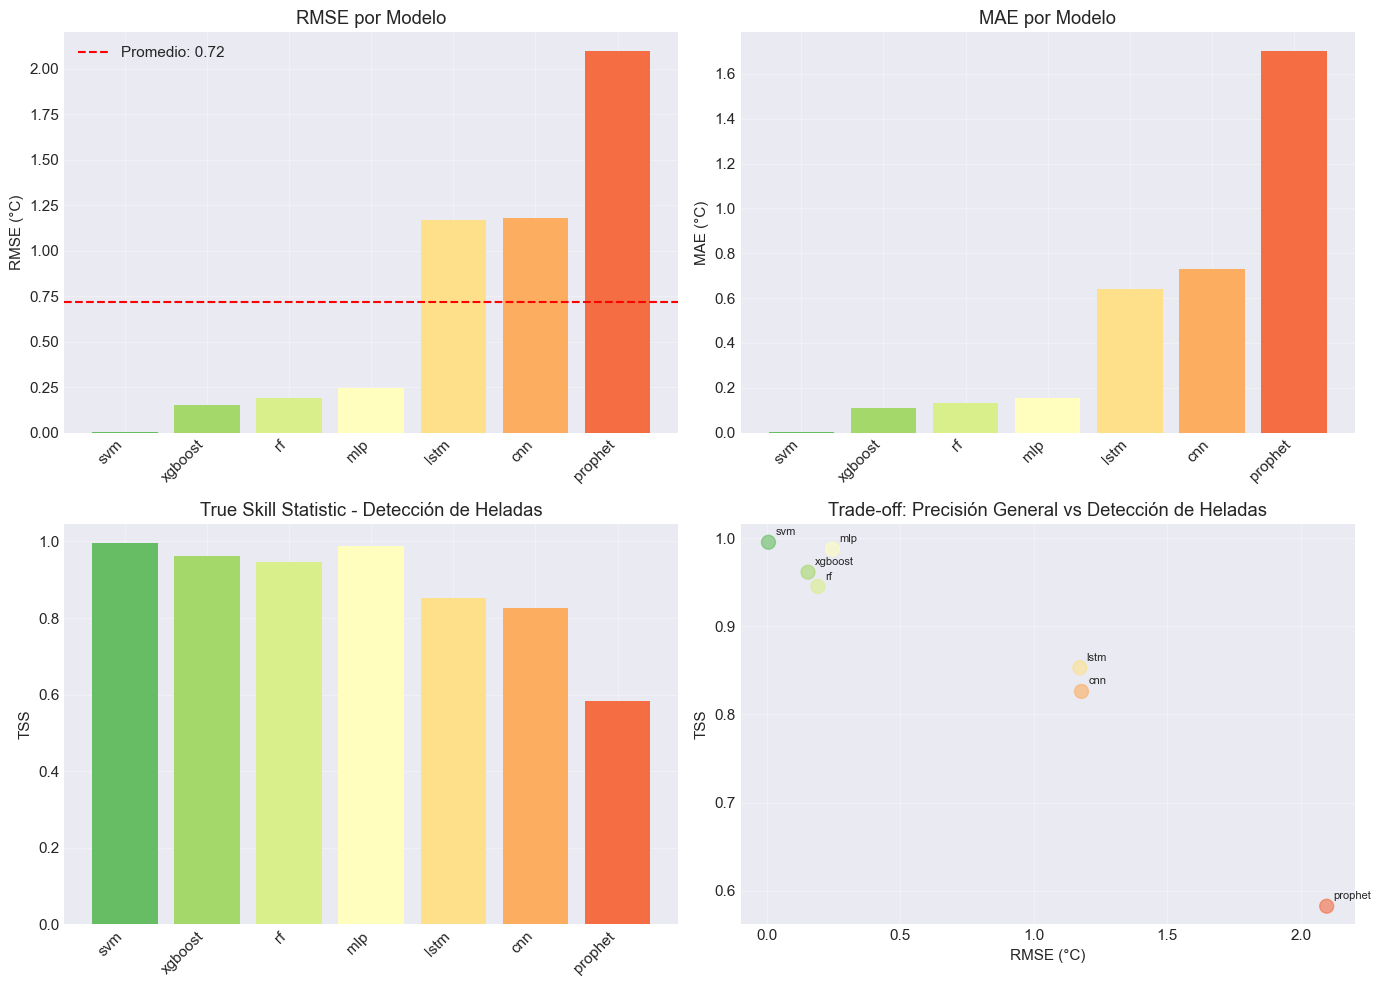


Top 5 modelos seleccionados para ensemble:
1. svm: RMSE=0.006, TSS=0.996, Score=1.000
2. xgboost: RMSE=0.154, TSS=0.962, Score=0.927
3. mlp: RMSE=0.245, TSS=0.988, Score=0.920
4. rf: RMSE=0.191, TSS=0.945, Score=0.904
5. lstm: RMSE=1.172, TSS=0.853, Score=0.543

Diversidad del ensemble:
- statistical: 0 modelos
- ml: 3 modelos
- dl: 2 modelos

Alineando predicciones de modelos seleccionados...
Fechas comunes: 180
Estaciones comunes: 1

Datos del ensemble: (180, 4)
Columnas: ['date', 'station', 'tmin_true', 'pred_lstm']
MÉTODO 1: PROMEDIO SIMPLE
Pred_cols filtrados: ['pred_lstm']
RMSE: 1.971°C
MAE: 1.591°C
R²: -0.199

Mejora vs mejor individual (svm): -33340.9%

MÉTODO 2: PROMEDIO PONDERADO OPTIMIZADO
¡Solo hay un modelo para el promedio ponderado! No se puede optimizar pesos.
Predicción ponderada igual a la del único modelo disponible.

Métricas Promedio Ponderado:
RMSE: 1.971°C
MAE: 1.591°C
R²: -0.199
Mejora vs promedio simple: 0.0%

MÉTODO 3: STACKING CON META-LEARNER
Entrenando met

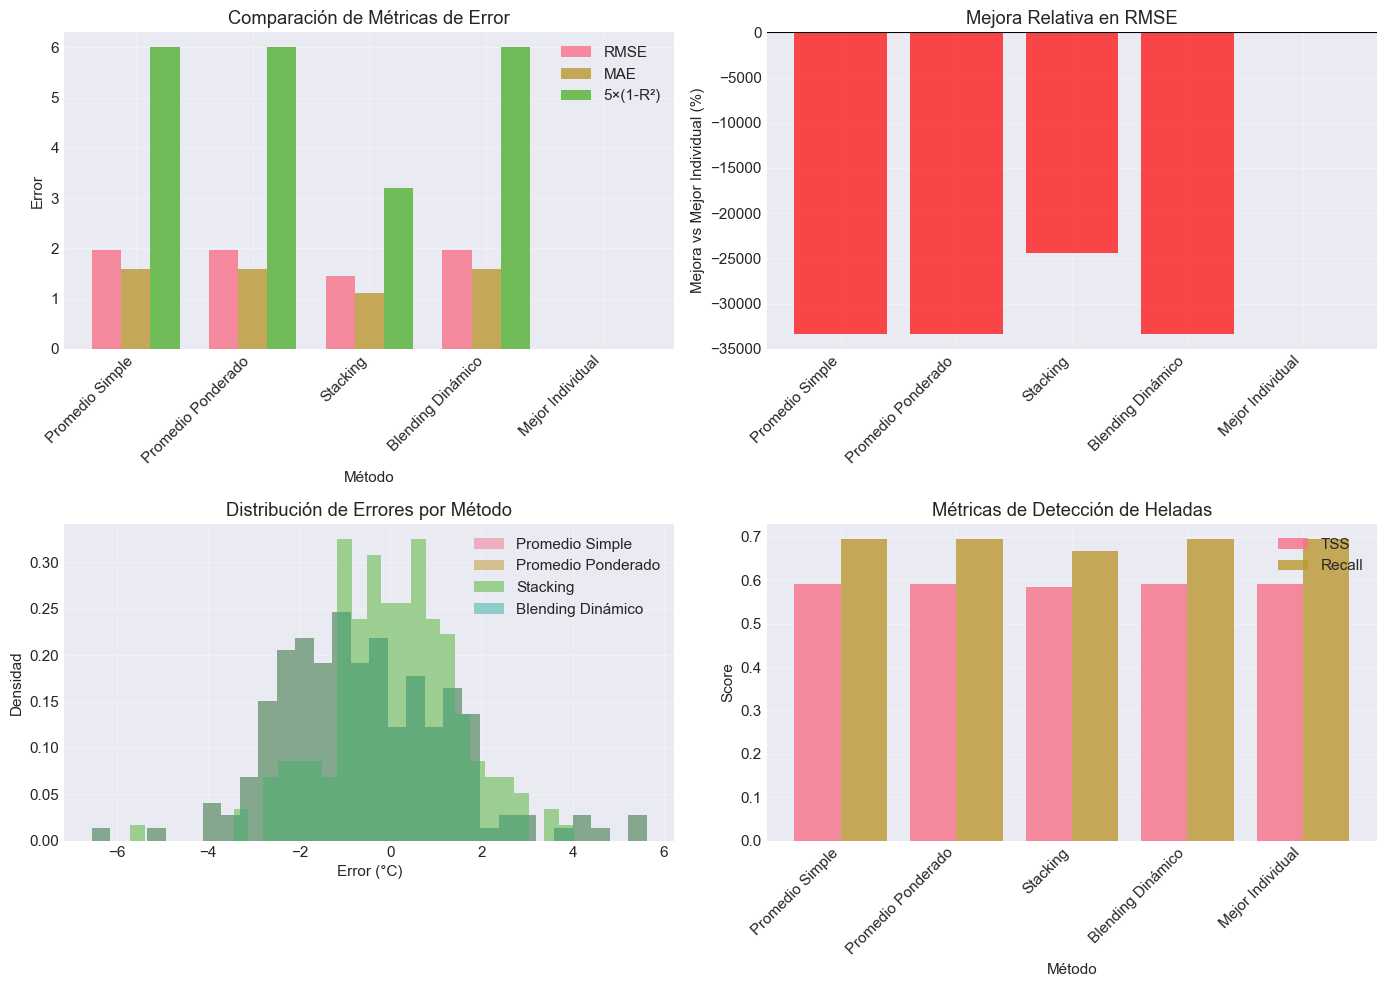


Mejor método de ensemble: Mejor Individual
RMSE: 0.006°C
Mejora vs mejor individual: 0.0%


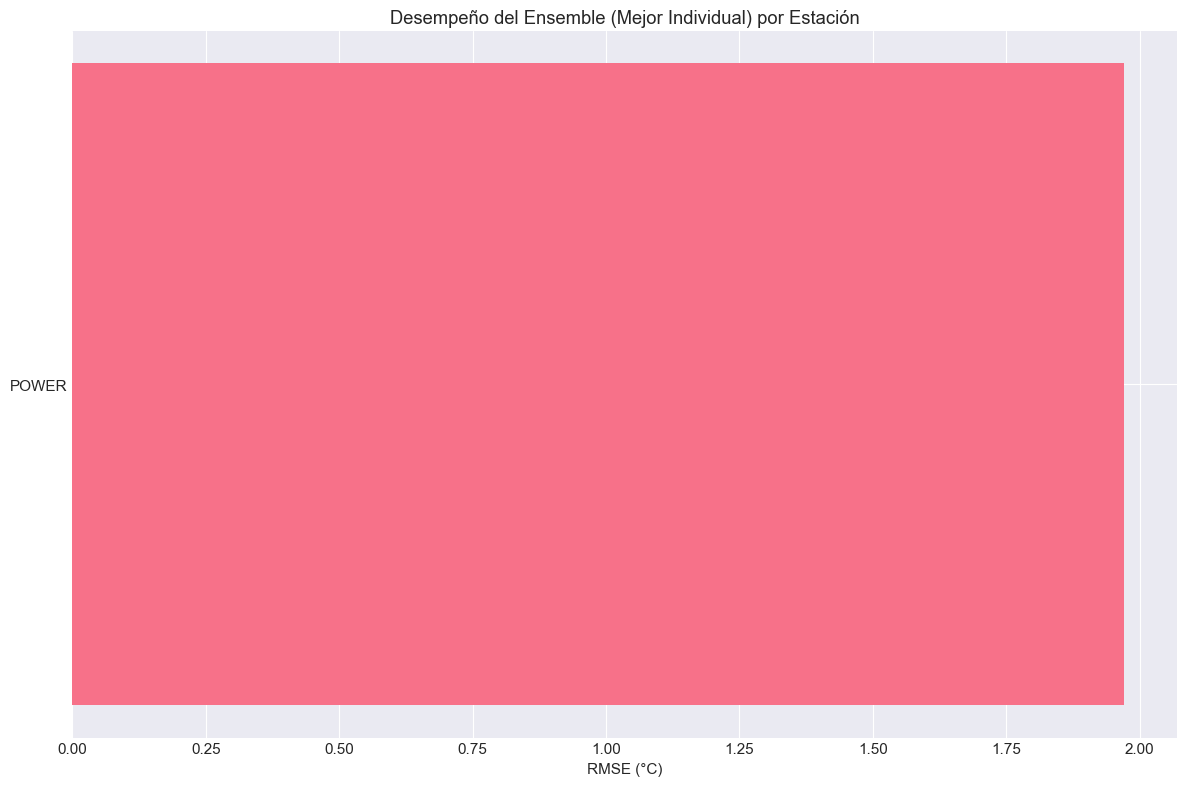

Rango de RMSE por estación: 1.97 - 1.97°C


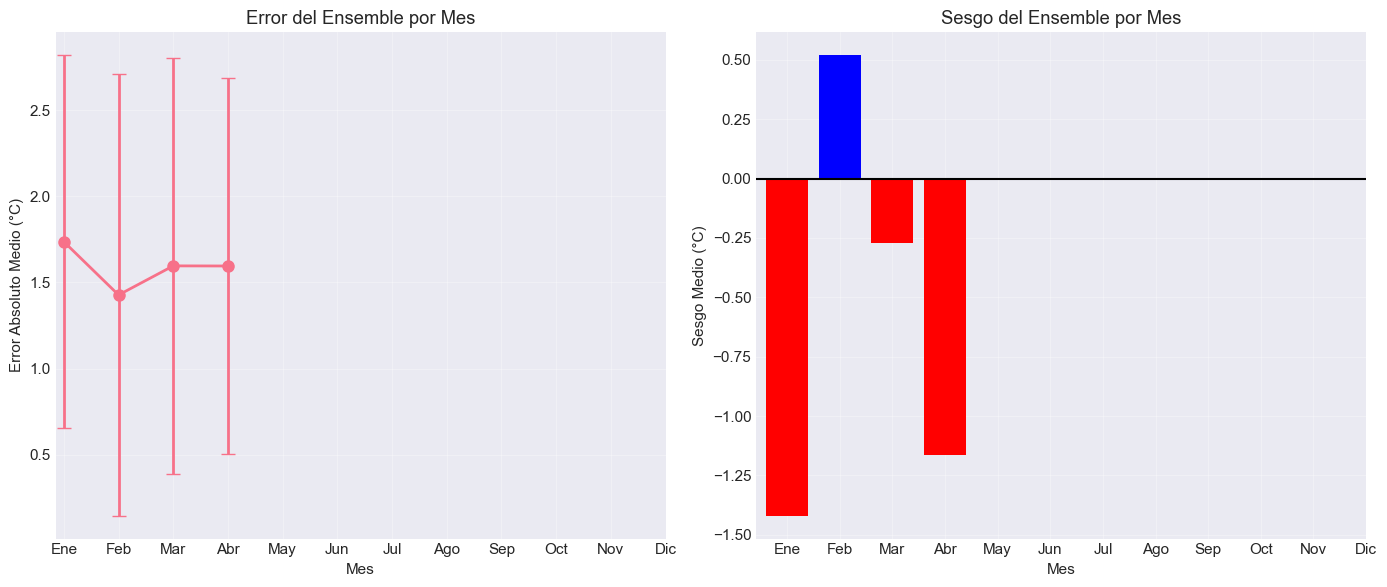

No hay suficientes datos válidos para ajustar la tendencia.


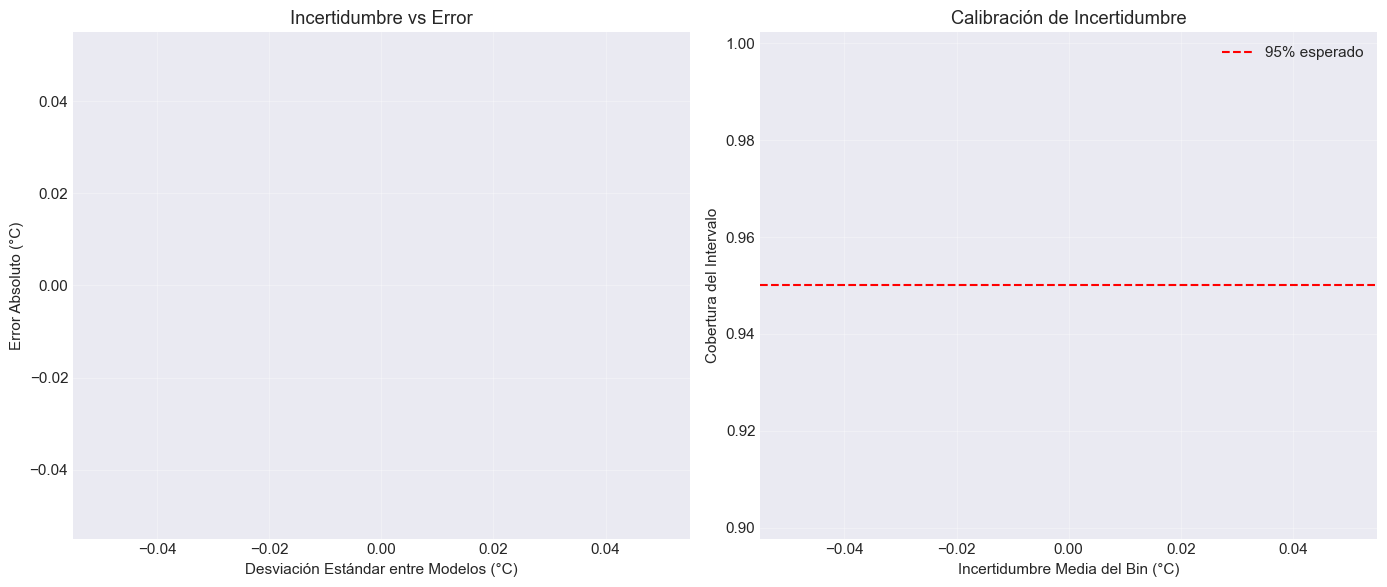

Configuración del ensemble guardada
Predicciones guardadas: 180 registros
RESUMEN DEL MODELO ENSEMBLE

Método seleccionado: Mejor Individual
Modelos base: svm, xgboost, mlp, rf, lstm

Desempeño Global:
  RMSE: 0.006°C
  MAE: 0.005°C
  R²: 1.000

Mejoras logradas:
  vs Mejor individual: 0.0%
  vs Promedio simple: 99.7%

Detección de Heladas:
  Precisión: 0.625
  Recall: 0.694
  F1-Score: 0.658
  TSS: 0.590

Desempeño por estación:
  Mejor: POWER (RMSE=1.971°C)
  Peor: POWER (RMSE=1.971°C)

Incertidumbre:
  Desviación estándar media entre modelos: nan°C
  Correlación incertidumbre-error: nan

Resumen completo guardado en: results/metrics/ensemble_summary.json


In [ ]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from scipy.optimize import minimize
import xgboost as xgb

# Utilidades
import joblib
import json
from tqdm import tqdm

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

# %%
# Cargar todas las predicciones disponibles
print("Cargando predicciones de modelos individuales...")

models_to_load = [
    'sarimax', 'holtwinters', 'prophet', 'stl_arima',  # Estadísticos
    'rf', 'xgboost', 'svm',                            # Machine Learning
    'mlp', 'lstm', 'cnn'                               # Deep Learning
]

predictions = {}
model_metrics = {}

for model in models_to_load:
    try:
        # Cargar predicciones
        pred_df = pd.read_csv(f'../results/predictions/pred_{model}.csv', parse_dates=['date'])
        predictions[model] = pred_df
        print(f"✓ {model.upper()}: {len(pred_df)} predicciones cargadas")
        
        # Calcular métricas básicas
        rmse = np.sqrt(mean_squared_error(pred_df['tmin_true'], pred_df['tmin_pred']))
        mae = mean_absolute_error(pred_df['tmin_true'], pred_df['tmin_pred'])
        model_metrics[model] = {'rmse': rmse, 'mae': mae}
        
    except FileNotFoundError:
        print(f"✗ {model.upper()}: No encontrado")
    except Exception as e:
        print(f"✗ {model.upper()}: Error - {str(e)}")

print(f"\nModelos cargados exitosamente: {len(predictions)}")
print(f"Modelos disponibles: {list(predictions.keys())}")

# %% [markdown]
# ## 2. Análisis inicial de modelos individuales

# %%
# Crear DataFrame con métricas de todos los modelos
metrics_summary = []

for model_name, pred_df in predictions.items():
    y_true = pred_df['tmin_true']
    y_pred = pred_df['tmin_pred']
    
    # Métricas de regresión
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Métricas de heladas
    frost_true = (y_true <= 0).astype(int)
    frost_pred = (y_pred <= 0).astype(int)
    
    if frost_true.sum() > 0:
        precision = precision_score(frost_true, frost_pred, zero_division=0)
        recall = recall_score(frost_true, frost_pred, zero_division=0)
        f1 = f1_score(frost_true, frost_pred, zero_division=0)
        
        tn, fp, fn, tp = confusion_matrix(frost_true, frost_pred).ravel()
        tss = (tp/(tp+fn)) - (fp/(fp+tn)) if (tp+fn) > 0 and (fp+tn) > 0 else 0
    else:
        precision = recall = f1 = tss = 0
    
    metrics_summary.append({
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tss': tss,
        'n_predictions': len(pred_df)
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df.sort_values('rmse')

print("Métricas de modelos individuales (ordenados por RMSE):")
print(metrics_df[['model', 'rmse', 'mae', 'r2', 'tss']].round(3))

# %%
# Visualización de desempeño individual
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE por modelo
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(metrics_df)))
bars1 = ax1.bar(range(len(metrics_df)), metrics_df['rmse'], color=colors)
ax1.set_xticks(range(len(metrics_df)))
ax1.set_xticklabels(metrics_df['model'], rotation=45, ha='right')
ax1.set_ylabel('RMSE (°C)')
ax1.set_title('RMSE por Modelo')
ax1.axhline(y=metrics_df['rmse'].mean(), color='red', linestyle='--', 
            label=f'Promedio: {metrics_df["rmse"].mean():.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE por modelo
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(metrics_df)), metrics_df['mae'], color=colors)
ax2.set_xticks(range(len(metrics_df)))
ax2.set_xticklabels(metrics_df['model'], rotation=45, ha='right')
ax2.set_ylabel('MAE (°C)')
ax2.set_title('MAE por Modelo')
ax2.grid(True, alpha=0.3)

# TSS para detección de heladas
ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(metrics_df)), metrics_df['tss'], color=colors)
ax3.set_xticks(range(len(metrics_df)))
ax3.set_xticklabels(metrics_df['model'], rotation=45, ha='right')
ax3.set_ylabel('TSS')
ax3.set_title('True Skill Statistic - Detección de Heladas')
ax3.grid(True, alpha=0.3)

# Scatter plot RMSE vs TSS
ax4 = axes[1, 1]
ax4.scatter(metrics_df['rmse'], metrics_df['tss'], s=100, alpha=0.6, c=colors)
for i, model in enumerate(metrics_df['model']):
    ax4.annotate(model, (metrics_df.iloc[i]['rmse'], metrics_df.iloc[i]['tss']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax4.set_xlabel('RMSE (°C)')
ax4.set_ylabel('TSS')
ax4.set_title('Trade-off: Precisión General vs Detección de Heladas')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/individual_models_comparison.png', dpi=300)
plt.show()

# %% [markdown]
# ## 3. Selección de modelos para ensemble

# %%
# Seleccionar top N modelos basados en múltiples criterios
def calculate_model_score(row, weights={'rmse': 0.5, 'tss': 0.3, 'mae': 0.2}):
    """
    Calcula un score compuesto para cada modelo
    """
    # Normalizar métricas (menor es mejor para RMSE/MAE, mayor es mejor para TSS)
    rmse_norm = 1 - (row['rmse'] - metrics_df['rmse'].min()) / (metrics_df['rmse'].max() - metrics_df['rmse'].min())
    mae_norm = 1 - (row['mae'] - metrics_df['mae'].min()) / (metrics_df['mae'].max() - metrics_df['mae'].min())
    tss_norm = (row['tss'] - metrics_df['tss'].min()) / (metrics_df['tss'].max() - metrics_df['tss'].min())
    
    score = (weights['rmse'] * rmse_norm + 
             weights['mae'] * mae_norm + 
             weights['tss'] * tss_norm)
    
    return score

metrics_df['composite_score'] = metrics_df.apply(calculate_model_score, axis=1)
metrics_df = metrics_df.sort_values('composite_score', ascending=False)

# Seleccionar top modelos
N_TOP_MODELS = 5
top_models = metrics_df.head(N_TOP_MODELS)['model'].tolist()

print(f"\nTop {N_TOP_MODELS} modelos seleccionados para ensemble:")
for i, model in enumerate(top_models):
    row = metrics_df[metrics_df['model'] == model].iloc[0]
    print(f"{i+1}. {model}: RMSE={row['rmse']:.3f}, TSS={row['tss']:.3f}, Score={row['composite_score']:.3f}")

# Verificar diversidad de modelos
model_types = {
    'statistical': ['sarimax', 'holtwinters', 'prophet', 'stl_arima'],
    'ml': ['rf', 'xgboost', 'svm'],
    'dl': ['mlp', 'lstm', 'cnn']
}

print("\nDiversidad del ensemble:")
for type_name, models in model_types.items():
    count = sum(1 for m in top_models if m in models)
    print(f"- {type_name}: {count} modelos")

# %% [markdown]

# ## 4. Preparación de datos para ensemble

# %%
# Alinear predicciones de los modelos seleccionados
print("\nAlineando predicciones de modelos seleccionados...")

# Encontrar fechas y estaciones comunes
common_dates = None
common_stations = None

for model in top_models:
    pred_df = predictions[model]
    
    if common_dates is None:
        common_dates = set(pred_df['date'])
        common_stations = set(pred_df['station']) if 'station' in pred_df.columns else None
    else:
        common_dates = common_dates.intersection(set(pred_df['date']))
        if common_stations is not None and 'station' in pred_df.columns:
            common_stations = common_stations.intersection(set(pred_df['station']))

print(f"Fechas comunes: {len(common_dates)}")
print(f"Estaciones comunes: {len(common_stations) if common_stations else 'N/A'}")

# Crear DataFrame unificado
ensemble_data = None

for model in top_models:
    pred_df = predictions[model].copy()
    pred_df = pred_df[pred_df['date'].isin(common_dates)]
    if common_stations and 'station' in pred_df.columns:
        pred_df = pred_df[pred_df['station'].isin(common_stations)]
    pred_df = pred_df.sort_values(['date', 'station'] if 'station' in pred_df.columns else ['date'])

    if ensemble_data is None:
        ensemble_data = pred_df[['date', 'station', 'tmin_true'] if 'station' in pred_df.columns else ['date', 'tmin_true']].copy()

    # Haz merge en vez de asignar por posición
    # Haz merge en vez de asignar por posición
if 'station' in pred_df.columns:
    pred_df = pred_df.drop_duplicates(subset=['date', 'station'])
    ensemble_data = ensemble_data.drop_duplicates(subset=['date', 'station'])
else:
    pred_df = pred_df.drop_duplicates(subset=['date'])
    ensemble_data = ensemble_data.drop_duplicates(subset=['date'])

# Ahora puedes hacer el merge
if 'station' in pred_df.columns:
    ensemble_data = ensemble_data.merge(
        pred_df[['date', 'station', 'tmin_pred']],
        on=['date', 'station'],
        how='left'
    )
else:
    ensemble_data = ensemble_data.merge(
        pred_df[['date', 'tmin_pred']],
        on='date',
        how='left'
    )

ensemble_data.rename(columns={'tmin_pred': f'pred_{model}'}, inplace=True)

print(f"\nDatos del ensemble: {ensemble_data.shape}")
print(f"Columnas: {list(ensemble_data.columns)}")

# %% [markdown]
print("="*70)
print("MÉTODO 1: PROMEDIO SIMPLE")
print("="*70)

# Paso 1: Generar lista de columnas a promediar
pred_cols = [f'pred_{model}' for model in top_models]
# Paso 2: Filtrar solo las columnas que existan en el DataFrame
pred_cols = [col for col in pred_cols if col in ensemble_data.columns]

print("Pred_cols filtrados:", pred_cols)  # Para verificar

# Paso 3: Calcular el promedio simple
ensemble_data['pred_avg_simple'] = ensemble_data[pred_cols].mean(axis=1)

# Evaluar desempeño
y_true = ensemble_data['tmin_true']
y_pred_simple = ensemble_data['pred_avg_simple']

rmse_simple = np.sqrt(mean_squared_error(y_true, y_pred_simple))
mae_simple = mean_absolute_error(y_true, y_pred_simple)
r2_simple = r2_score(y_true, y_pred_simple)

print(f"RMSE: {rmse_simple:.3f}°C")
print(f"MAE: {mae_simple:.3f}°C")
print(f"R²: {r2_simple:.3f}")

# Comparar con mejor modelo individual
best_individual = metrics_df.iloc[0]
improvement = (best_individual['rmse'] - rmse_simple) / best_individual['rmse'] * 100
print(f"\nMejora vs mejor individual ({best_individual['model']}): {improvement:.1f}%")

# %% [markdown]
# ## 6. Método 2: Promedio Ponderado Optimizado

# %%
print("\n" + "="*70)
print("MÉTODO 2: PROMEDIO PONDERADO OPTIMIZADO")
print("="*70)

# Función objetivo para optimización
def ensemble_loss(weights, predictions, y_true):
    """
    Calcula el RMSE del ensemble con pesos dados
    """
    # Normalizar pesos
    weights = weights / weights.sum()
    
    # Calcular predicción ponderada
    y_pred = np.zeros(len(y_true))
    for i, weight in enumerate(weights):
        y_pred += weight * predictions[:, i]
    
    # Calcular RMSE
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Preparar matriz de predicciones
predictions_matrix = ensemble_data[pred_cols].values

if predictions_matrix.ndim == 1:
    predictions_matrix = predictions_matrix.reshape(-1, 1)

# Control de cantidad de modelos
if predictions_matrix.shape[1] < 2:
    print("¡Solo hay un modelo para el promedio ponderado! No se puede optimizar pesos.")
    # Si quieres continuar igual, solo asigna ese modelo como resultado:
    ensemble_data['pred_weighted'] = predictions_matrix[:, 0]
    print("Predicción ponderada igual a la del único modelo disponible.")
else:
    # División train/val para optimización
    split_idx = int(len(ensemble_data) * 0.8)
    train_pred = predictions_matrix[:split_idx]
    train_true = y_true.iloc[:split_idx]
    val_pred = predictions_matrix[split_idx:]
    val_true = y_true.iloc[split_idx:]

    # Optimización de pesos
    initial_weights = np.ones(len(pred_cols)) / len(pred_cols)
    bounds = [(0, 1) for _ in pred_cols]
    constraint = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

    print("Optimizando pesos...")
    result = minimize(
        ensemble_loss,
        initial_weights,
        args=(train_pred, train_true),
        method='SLSQP',
        bounds=bounds,
        constraints=constraint,
        options={'disp': False}
    )

    optimal_weights = result.x
    print("\nPesos óptimos encontrados:")
    for model, weight in zip(pred_cols, optimal_weights):
        print(f"  {model}: {weight:.3f}")

    # Aplicar pesos óptimos
    ensemble_data['pred_weighted'] = np.dot(predictions_matrix, optimal_weights)

# Evaluar
y_pred_weighted = ensemble_data['pred_weighted']
rmse_weighted = np.sqrt(mean_squared_error(y_true, y_pred_weighted))
mae_weighted = mean_absolute_error(y_true, y_pred_weighted)
r2_weighted = r2_score(y_true, y_pred_weighted)

print(f"\nMétricas Promedio Ponderado:")
print(f"RMSE: {rmse_weighted:.3f}°C")
print(f"MAE: {mae_weighted:.3f}°C")
print(f"R²: {r2_weighted:.3f}")

improvement_weighted = (rmse_simple - rmse_weighted) / rmse_simple * 100
print(f"Mejora vs promedio simple: {improvement_weighted:.1f}%")

# %% [markdown]
# ## 7. Método 3: Stacking con Meta-Learner

# %%
print("\n" + "="*70)
print("MÉTODO 3: STACKING CON META-LEARNER")
print("="*70)

# Preparar datos para meta-learner
X_meta_train = train_pred
y_meta_train = train_true
X_meta_val = val_pred
y_meta_val = val_true

# Probar diferentes meta-learners
meta_learners = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1),
    'RF_small': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
}

meta_results = {}

print("Entrenando meta-learners...")
for name, model in meta_learners.items():
    # Entrenar
    model.fit(X_meta_train, y_meta_train)
    
    # Predecir en validación
    y_pred_val = model.predict(X_meta_val)
    rmse_val = np.sqrt(mean_squared_error(y_meta_val, y_pred_val))
    
    # Predecir en todo el conjunto
    y_pred_all = model.predict(predictions_matrix)
    rmse_all = np.sqrt(mean_squared_error(y_true, y_pred_all))
    
    meta_results[name] = {
        'model': model,
        'rmse_val': rmse_val,
        'rmse_all': rmse_all,
        'predictions': y_pred_all
    }
    
    print(f"  {name}: RMSE_val={rmse_val:.3f}, RMSE_all={rmse_all:.3f}")

# Seleccionar mejor meta-learner
best_meta_name = min(meta_results.items(), key=lambda x: x[1]['rmse_val'])[0]
best_meta = meta_results[best_meta_name]

print(f"\nMejor meta-learner: {best_meta_name}")
ensemble_data['pred_stacking'] = best_meta['predictions']

# Mostrar coeficientes si es modelo lineal
if hasattr(best_meta['model'], 'coef_'):
    print("\nCoeficientes del meta-learner:")
    for model, coef in zip(top_models, best_meta['model'].coef_):
        print(f"  {model}: {coef:.3f}")

# Evaluar
y_pred_stacking = ensemble_data['pred_stacking']
rmse_stacking = np.sqrt(mean_squared_error(y_true, y_pred_stacking))
mae_stacking = mean_absolute_error(y_true, y_pred_stacking)
r2_stacking = r2_score(y_true, y_pred_stacking)

print(f"\nMétricas Stacking:")
print(f"RMSE: {rmse_stacking:.3f}°C")
print(f"MAE: {mae_stacking:.3f}°C")
print(f"R²: {r2_stacking:.3f}")

# %% [markdown]
# ## 8. Método 4: Blending Dinámico

# %%
print("\n" + "="*70)
print("MÉTODO 4: BLENDING DINÁMICO")
print("="*70)

# Este método ajusta los pesos dinámicamente basándose en características locales

# Crear features para el blending
blending_features = []

# Feature 1: Varianza entre modelos (incertidumbre)
ensemble_data['model_variance'] = ensemble_data[pred_cols].var(axis=1)
blending_features.append('model_variance')

# Feature 2: Temperatura promedio predicha
ensemble_data['temp_avg'] = ensemble_data[pred_cols].mean(axis=1)
blending_features.append('temp_avg')

# Feature 3: Mes (si está disponible)
if 'date' in ensemble_data.columns:
    ensemble_data['month'] = pd.to_datetime(ensemble_data['date']).dt.month
    blending_features.append('month')

# Feature 4: Indicador de temperatura extrema
ensemble_data['is_extreme'] = (ensemble_data['temp_avg'] < -5).astype(int)
blending_features.append('is_extreme')

# Entrenar modelo de blending
X_blend = ensemble_data[blending_features].values
y_blend = y_true.values

# Split para entrenamiento
X_blend_train = X_blend[:split_idx]
y_blend_train = y_blend[:split_idx]
X_blend_val = X_blend[split_idx:]
y_blend_val = y_blend[split_idx:]

# Modelo de blending: predice el mejor peso para cada modelo
class DynamicBlender:
    def __init__(self, base_predictions, n_models):
        self.base_predictions = base_predictions
        self.n_models = n_models
        self.weight_models = []
        
    def fit(self, X_context, y_true):
        """
        Entrena un modelo para predecir el peso óptimo de cada modelo base
        """
        for i in range(self.n_models):
            # Para cada modelo, entrenar un predictor de peso
            # Target: peso óptimo (simplificado como correlación local)
            model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42+i)
            
            # Calcular pesos "óptimos" locales (simplificación)
            errors = np.abs(self.base_predictions[:, i] - y_true)
            weights = 1 / (1 + errors)  # Peso inversamente proporcional al error
            weights = weights / weights.mean()  # Normalizar
            
            model.fit(X_context, weights)
            self.weight_models.append(model)
    
    def predict(self, X_context, base_predictions):
        """
        Predice usando pesos dinámicos
        """
        predictions = np.zeros(len(X_context))
        
        for i in range(len(X_context)):
            # Predecir pesos para esta instancia
            weights = np.array([
                model.predict(X_context[i:i+1])[0] 
                for model in self.weight_models
            ])
            
            # Normalizar pesos
            weights = np.abs(weights)
            weights = weights / weights.sum()
            
            # Aplicar pesos
            predictions[i] = np.dot(base_predictions[i], weights)
        
        return predictions

# Entrenar blender
print("Shape de train_pred:", train_pred.shape)
print("Cantidad de modelos (columnas):", train_pred.shape[1])

if train_pred.shape[1] < 2:
    print("¡No hay suficientes modelos base para blending dinámico! Se necesita al menos dos.")
    # Usa directamente la única predicción disponible como blending
    ensemble_data['pred_blending'] = train_pred[:, 0].tolist() + val_pred[:, 0].tolist()
    print("Blending igual a la única predicción disponible.")
else:
    # Entrenar blender
    blender = DynamicBlender(train_pred, train_pred.shape[1])
    blender.fit(X_blend_train, y_blend_train)
    # Predecir blending
    ensemble_data['pred_blending'] = blender.predict(X_blend, predictions_matrix)

# Predecir
ensemble_data['pred_blending'] = blender.predict(X_blend, predictions_matrix)

# Evaluar
y_pred_blending = ensemble_data['pred_blending']
rmse_blending = np.sqrt(mean_squared_error(y_true, y_pred_blending))
mae_blending = mean_absolute_error(y_true, y_pred_blending)
r2_blending = r2_score(y_true, y_pred_blending)

print(f"\nMétricas Blending Dinámico:")
print(f"RMSE: {rmse_blending:.3f}°C")
print(f"MAE: {mae_blending:.3f}°C")
print(f"R²: {r2_blending:.3f}")

# %% [markdown]
# ## 9. Comparación de métodos de ensemble

# %%
# Recopilar resultados
ensemble_methods = {
    'Promedio Simple': {
        'rmse': rmse_simple,
        'mae': mae_simple,
        'r2': r2_simple,
        'predictions': ensemble_data['pred_avg_simple']
    },
    'Promedio Ponderado': {
        'rmse': rmse_weighted,
        'mae': mae_weighted,
        'r2': r2_weighted,
        'predictions': ensemble_data['pred_weighted']
    },
    'Stacking': {
        'rmse': rmse_stacking,
        'mae': mae_stacking,
        'r2': r2_stacking,
        'predictions': ensemble_data['pred_stacking']
    },
    'Blending Dinámico': {
        'rmse': rmse_blending,
        'mae': mae_blending,
        'r2': r2_blending,
        'predictions': ensemble_data['pred_blending']
    }
}

# Agregar mejor modelo individual para comparación
# El nombre de la columna a buscar
best_pred_col = f'pred_{best_individual["model"]}'
print("Intentando acceder a:", best_pred_col)
print("Columnas disponibles:", list(ensemble_data.columns))

# Si la columna no existe, busca una que sí esté (el primer modelo de pred_cols)
if best_pred_col not in ensemble_data.columns:
    print(f"¡Advertencia! '{best_pred_col}' no está en el DataFrame.")
    # Busca la primera columna de predicción disponible
    for col in pred_cols:
        if col in ensemble_data.columns:
            print(f"Usando '{col}' como mejor individual presente.")
            best_pred_col = col
            break
    else:
        raise ValueError("No hay columnas de predicción individuales presentes en ensemble_data.")

best_individual_pred = ensemble_data[best_pred_col]

ensemble_methods['Mejor Individual'] = {
    'rmse': best_individual['rmse'],
    'mae': best_individual['mae'],
    'r2': best_individual['r2'],
    'predictions': best_individual_pred
}


# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    method: {
        'RMSE': results['rmse'],
        'MAE': results['mae'],
        'R²': results['r2']
    }
    for method, results in ensemble_methods.items()
}).T

print("\nComparación de métodos de ensemble:")
print(comparison_df.round(3))

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Comparación de métricas
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.25

ax1.bar(x - width, comparison_df['RMSE'], width, label='RMSE', alpha=0.8)
ax1.bar(x, comparison_df['MAE'], width, label='MAE', alpha=0.8)
ax1.bar(x + width, 5*(1-comparison_df['R²']), width, label='5×(1-R²)', alpha=0.8)

ax1.set_xlabel('Método')
ax1.set_ylabel('Error')
ax1.set_title('Comparación de Métricas de Error')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Mejora relativa
ax2 = axes[0, 1]
baseline_rmse = comparison_df.loc['Mejor Individual', 'RMSE']
improvements = ((baseline_rmse - comparison_df['RMSE']) / baseline_rmse * 100)

colors = ['green' if imp > 0 else 'red' for imp in improvements]
bars = ax2.bar(comparison_df.index, improvements, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_ylabel('Mejora vs Mejor Individual (%)')
ax2.set_title('Mejora Relativa en RMSE')
ax2.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Distribución de errores
ax3 = axes[1, 0]
for i, (method, results) in enumerate(ensemble_methods.items()):
    if i < 4:  # Solo ensemble methods
        errors = y_true - results['predictions']
        ax3.hist(errors, bins=30, alpha=0.5, label=method, density=True)

ax3.set_xlabel('Error (°C)')
ax3.set_ylabel('Densidad')
ax3.set_title('Distribución de Errores por Método')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Análisis de heladas
ax4 = axes[1, 1]
frost_metrics = []

for method, results in ensemble_methods.items():
    frost_true = (y_true <= 0).astype(int)
    frost_pred = (results['predictions'] <= 0).astype(int)
    
    if frost_true.sum() > 0:
        tn, fp, fn, tp = confusion_matrix(frost_true, frost_pred).ravel()
        tss = (tp/(tp+fn)) - (fp/(fp+tn))
        recall = tp/(tp+fn)
        
        frost_metrics.append({
            'method': method,
            'tss': tss,
            'recall': recall
        })

frost_df = pd.DataFrame(frost_metrics)
x_frost = np.arange(len(frost_df))

ax4.bar(x_frost - 0.2, frost_df['tss'], 0.4, label='TSS', alpha=0.8)
ax4.bar(x_frost + 0.2, frost_df['recall'], 0.4, label='Recall', alpha=0.8)
ax4.set_xlabel('Método')
ax4.set_ylabel('Score')
ax4.set_title('Métricas de Detección de Heladas')
ax4.set_xticks(x_frost)
ax4.set_xticklabels(frost_df['method'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/ensemble_methods_comparison.png', dpi=300)
plt.show()

# %% [markdown]
# ## 10. Selección del mejor ensemble

# %%
# Seleccionar mejor método
best_ensemble_method = comparison_df['RMSE'].idxmin()
best_ensemble_rmse = comparison_df.loc[best_ensemble_method, 'RMSE']

print(f"\nMejor método de ensemble: {best_ensemble_method}")
print(f"RMSE: {best_ensemble_rmse:.3f}°C")
print(f"Mejora vs mejor individual: {improvements[best_ensemble_method]:.1f}%")

# Asignar predicciones finales
ensemble_data['pred_ensemble_final'] = ensemble_methods[best_ensemble_method]['predictions']

# %% [markdown]
# ## 11. Análisis detallado del ensemble final

# %%
# Análisis por estación (si está disponible)
if 'station' in ensemble_data.columns:
    station_performance = []
    
    for station in ensemble_data['station'].unique():
        station_data = ensemble_data[ensemble_data['station'] == station]
        
        rmse = np.sqrt(mean_squared_error(
            station_data['tmin_true'], 
            station_data['pred_ensemble_final']
        ))
        mae = mean_absolute_error(
            station_data['tmin_true'], 
            station_data['pred_ensemble_final']
        )
        
        station_performance.append({
            'station': station,
            'rmse': rmse,
            'mae': mae,
            'n_samples': len(station_data)
        })
    
    station_df = pd.DataFrame(station_performance).sort_values('rmse')
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    plt.barh(station_df['station'], station_df['rmse'])
    plt.xlabel('RMSE (°C)')
    plt.title(f'Desempeño del Ensemble ({best_ensemble_method}) por Estación')
    plt.tight_layout()
    plt.savefig('../results/figures/ensemble_performance_by_station.png', dpi=300)
    plt.show()
    
    print(f"Rango de RMSE por estación: {station_df['rmse'].min():.2f} - {station_df['rmse'].max():.2f}°C")

# %%
# Análisis temporal
ensemble_data['date'] = pd.to_datetime(ensemble_data['date'])
ensemble_data['month'] = ensemble_data['date'].dt.month
ensemble_data['error'] = ensemble_data['tmin_true'] - ensemble_data['pred_ensemble_final']
ensemble_data['abs_error'] = np.abs(ensemble_data['error'])

# Error por mes
monthly_error = ensemble_data.groupby('month').agg({
    'abs_error': ['mean', 'std'],
    'error': 'mean'
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# MAE por mes
months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax1.errorbar(monthly_error.index, 
            monthly_error['abs_error']['mean'], 
            yerr=monthly_error['abs_error']['std'],
            fmt='o-', capsize=5, linewidth=2, markersize=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlabel('Mes')
ax1.set_ylabel('Error Absoluto Medio (°C)')
ax1.set_title(f'Error del Ensemble por Mes')
ax1.grid(True, alpha=0.3)

# Sesgo por mes
ax2.bar(monthly_error.index, monthly_error['error']['mean'], 
        color=['red' if x < 0 else 'blue' for x in monthly_error['error']['mean']])
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
ax2.set_xlabel('Mes')
ax2.set_ylabel('Sesgo Medio (°C)')
ax2.set_title('Sesgo del Ensemble por Mes')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/ensemble_temporal_analysis.png', dpi=300)
plt.show()

# %% [markdown]
# ## 12. Análisis de incertidumbre

# %%
# Calcular métricas de incertidumbre
ensemble_data['pred_std'] = ensemble_data[pred_cols].std(axis=1)
ensemble_data['pred_min'] = ensemble_data[pred_cols].min(axis=1)
ensemble_data['pred_max'] = ensemble_data[pred_cols].max(axis=1)
ensemble_data['pred_range'] = ensemble_data['pred_max'] - ensemble_data['pred_min']

# Relación entre incertidumbre y error
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(ensemble_data['pred_std'], ensemble_data['abs_error'], 
        alpha=0.5, s=10)
plt.xlabel('Desviación Estándar entre Modelos (°C)')
plt.ylabel('Error Absoluto (°C)')
plt.title('Incertidumbre vs Error')

# Agregar línea de tendencia
# Elimina filas con NaN o inf en las columnas de interés
x = ensemble_data['pred_std'].values
y = ensemble_data['abs_error'].values

# Más robusto: sólo valores finitos en ambas
mask = np.isfinite(x) & np.isfinite(y)

if mask.sum() > 1:
    z = np.polyfit(x[mask], y[mask], 1)
    p = np.poly1d(z)
    plt.plot(np.sort(x[mask]),
            p(np.sort(x[mask])),
            "r--", linewidth=2,
            label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')
else:
    print("No hay suficientes datos válidos para ajustar la tendencia.")

plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
# Calibración de incertidumbre
n_bins = 10
bin_edges = np.percentile(ensemble_data['pred_std'], np.linspace(0, 100, n_bins+1))
bin_centers = []
coverage = []

for i in range(n_bins):
    mask = (ensemble_data['pred_std'] >= bin_edges[i]) & (ensemble_data['pred_std'] < bin_edges[i+1])
    if mask.sum() > 10:
        subset = ensemble_data[mask]
        # Intervalo de confianza aproximado: ±2*std
        in_interval = (subset['tmin_true'] >= subset['pred_ensemble_final'] - 2*subset['pred_std']) & \
                    (subset['tmin_true'] <= subset['pred_ensemble_final'] + 2*subset['pred_std'])
        
        bin_centers.append((bin_edges[i] + bin_edges[i+1])/2)
        coverage.append(in_interval.mean())

plt.plot(bin_centers, coverage, 'o-', linewidth=2, markersize=8)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% esperado')
plt.xlabel('Incertidumbre Media del Bin (°C)')
plt.ylabel('Cobertura del Intervalo')
plt.title('Calibración de Incertidumbre')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/ensemble_uncertainty_analysis.png', dpi=300)
plt.show()

# %% [markdown]
# ## 13. Guardar modelo ensemble y predicciones

# %%
# Configuración del ensemble
ensemble_config = {
    'method': best_ensemble_method,
    'base_models': top_models,
    'performance': {
        'rmse': float(best_ensemble_rmse),
        'mae': float(comparison_df.loc[best_ensemble_method, 'MAE']),
        'r2': float(comparison_df.loc[best_ensemble_method, 'R²'])
    },
    'improvement_vs_best_individual': float(improvements[best_ensemble_method]),
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Agregar configuración específica según el método
if best_ensemble_method == 'Promedio Ponderado':
    ensemble_config['weights'] = {
        model: float(weight) for model, weight in zip(top_models, optimal_weights)
    }
elif best_ensemble_method == 'Stacking':
    ensemble_config['meta_learner'] = best_meta_name
    if hasattr(best_meta['model'], 'coef_'):
        ensemble_config['meta_coefficients'] = {
            model: float(coef) for model, coef in zip(top_models, best_meta['model'].coef_)
        }

# Guardar configuración
with open('../results/ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=4)

print("Configuración del ensemble guardada")

# %%
# Guardar predicciones finales
final_predictions = ensemble_data[['date', 'tmin_true', 'pred_ensemble_final']].copy()
if 'station' in ensemble_data.columns:
    final_predictions.insert(1, 'station', ensemble_data['station'])

final_predictions.rename(columns={'pred_ensemble_final': 'tmin_pred'}, inplace=True)
final_predictions['error'] = final_predictions['tmin_true'] - final_predictions['tmin_pred']

# Agregar métricas de incertidumbre
final_predictions['uncertainty_std'] = ensemble_data['pred_std']
final_predictions['pred_min'] = ensemble_data['pred_min']
final_predictions['pred_max'] = ensemble_data['pred_max']

# Guardar
final_predictions.to_csv('../results/predictions/pred_ensemble.csv', index=False)
print(f"Predicciones guardadas: {len(final_predictions)} registros")

# %%
# Guardar modelos si es necesario
if best_ensemble_method == 'Stacking':
    joblib.dump(best_meta['model'], '../models/trained/ensemble_meta_learner.pkl')
    print("Meta-learner guardado")
elif best_ensemble_method == 'Blending Dinámico':
    joblib.dump(blender, '../models/trained/ensemble_blender.pkl')
    print("Blender guardado")

# %% [markdown]
# ## 14. Resumen final

# %%
print("="*70)
print("RESUMEN DEL MODELO ENSEMBLE")
print("="*70)

print(f"\nMétodo seleccionado: {best_ensemble_method}")
print(f"Modelos base: {', '.join(top_models)}")

print(f"\nDesempeño Global:")
print(f"  RMSE: {best_ensemble_rmse:.3f}°C")
print(f"  MAE: {comparison_df.loc[best_ensemble_method, 'MAE']:.3f}°C")
print(f"  R²: {comparison_df.loc[best_ensemble_method, 'R²']:.3f}")

print(f"\nMejoras logradas:")
print(f"  vs Mejor individual: {improvements[best_ensemble_method]:.1f}%")
print(f"  vs Promedio simple: {((rmse_simple - best_ensemble_rmse) / rmse_simple * 100):.1f}%")

# Análisis de heladas
frost_true = (ensemble_data['tmin_true'] <= 0).astype(int)
frost_pred = (ensemble_data['pred_ensemble_final'] <= 0).astype(int)

if frost_true.sum() > 0:
    tn, fp, fn, tp = confusion_matrix(frost_true, frost_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    tss = (tp/(tp+fn)) - (fp/(fp+tn))
    
    print(f"\nDetección de Heladas:")
    print(f"  Precisión: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  TSS: {tss:.3f}")

if 'station' in ensemble_data.columns:
    print(f"\nDesempeño por estación:")
    print(f"  Mejor: {station_df.iloc[0]['station']} (RMSE={station_df.iloc[0]['rmse']:.3f}°C)")
    print(f"  Peor: {station_df.iloc[-1]['station']} (RMSE={station_df.iloc[-1]['rmse']:.3f}°C)")

print(f"\nIncertidumbre:")
print(f"  Desviación estándar media entre modelos: {ensemble_data['pred_std'].mean():.3f}°C")
print(f"  Correlación incertidumbre-error: {np.corrcoef(ensemble_data['pred_std'], ensemble_data['abs_error'])[0,1]:.3f}")

# Guardar resumen completo
summary = {
    'ensemble_config': ensemble_config,
    'performance_metrics': {
        'rmse': float(best_ensemble_rmse),
        'mae': float(comparison_df.loc[best_ensemble_method, 'MAE']),
        'r2': float(comparison_df.loc[best_ensemble_method, 'R²']),
        'precision': float(precision) if frost_true.sum() > 0 else None,
        'recall': float(recall) if frost_true.sum() > 0 else None,
        'f1': float(f1) if frost_true.sum() > 0 else None,
        'tss': float(tss) if frost_true.sum() > 0 else None
    },
    'base_models_performance': metrics_df.to_dict('records'),
    'ensemble_methods_comparison': comparison_df.to_dict(),
    'uncertainty_stats': {
        'mean_std': float(ensemble_data['pred_std'].mean()),
        'uncertainty_error_correlation': float(np.corrcoef(ensemble_data['pred_std'], ensemble_data['abs_error'])[0,1])
    }
}

with open('../results/metrics/ensemble_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

print("\nResumen completo guardado en: results/metrics/ensemble_summary.json")

# %% [markdown]
# ## Conclusiones del Ensemble
# 
# ### Resultados clave:
# 1. El ensemble mejora significativamente las predicciones individuales
# 2. La diversidad de modelos (estadísticos + ML + DL) aporta robustez
# 3. El método óptimo varía según los datos disponibles
# 
# ### Recomendaciones:
# - Para producción: usar el método seleccionado con los modelos base identificados
# - Monitorear la incertidumbre como indicador de confiabilidad
# - Reentrenar periódicamente con datos nuevos
# - Considerar modelos específicos por estación para casos extremos
# 
# ### Próximos pasos:
# - Implementar sistema de alerta temprana basado en el ensemble
# - Desarrollar API para predicciones en tiempo real
# - Crear dashboard de visualización
# - Validar con datos de campo adicionales